# Openclassrooms PJ5 : Online Retail dataset :  modelisation notebook 

In [1]:
%matplotlib inline

#%load_ext autoreload  # Autoreload has a bug : when you modify function in source code and run again, python kernel hangs :(
#%autoreload 2

import datetime as dt

import sys, importlib

from functions import *
importlib.reload(sys.modules['functions'])

import pandas as pd

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

import datetime as dt

import os
import zipfile
import urllib

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import qgrid

import glob

from pandas.plotting import scatter_matrix

from sklearn.model_selection import StratifiedShuffleSplit

from sklearn.model_selection import GridSearchCV

DATA_PATH = os.path.join("datasets", "onlineretail")
DATA_PATH = os.path.join(DATA_PATH, "out")

DATA_PATH_FILE_INPUT = os.path.join(DATA_PATH, "OnlineRetail_transformed.csv")


ALL_FEATURES = []

#MODEL_FEATURES=['InvoiceNo', 'InvoiceDate', 'CustomerID', 'TotalPrice', 'DescriptionNormalized', 'InvoiceMonth', 'StockCode']
MODEL_CLIENT_FEATURES = ['TotalPricePerMonth', 'DescriptionNormalized', 'HasEverCancelled', 'BoughtTopValueProduct' ]

plt.rcParams["figure.figsize"] = [16,9] # Taille par défaut des figures de matplotlib

import seaborn as sns
sns.set()

#import common_functions

####### Paramètres pour sauver et restaurer les modèles :
import pickle
####### Paramètres à changer par l'utilisateur selon son besoin :

RECOMPUTE_GRIDSEARCH = True  # CAUTION : computation is several hours long
SAVE_GRID_RESULTS = False # If True : grid results object will be saved to pickle files that have GRIDSEARCH_FILE_PREFIX
LOAD_GRID_RESULTS = False # If True : grid results object will be loaded from pickle files that have GRIDSEARCH_FILE_PREFIX
                          # Grid search results are loaded with full samples (SAMPLED_DATA must be False)

'''
RECOMPUTE_GRIDSEARCH = True  # CAUTION : computation is several hours long
SAVE_GRID_RESULTS = True # If True : grid results object will be saved to pickle files that have GRIDSEARCH_FILE_PREFIX
LOAD_GRID_RESULTS = False # If True : grid results object will be loaded from pickle files that have GRIDSEARCH_FILE_PREFIX
'''
#GRIDSEARCH_CSV_FILE = 'grid_search_results.csv'

GRIDSEARCH_FILE_PREFIX = 'grid_search_results_'

EXECUTE_INTERMEDIATE_MODELS = True # If True: every intermediate model (which results are manually analyzed in the notebook) will be executed


# Necessary for predictors used in the notebook :
from sklearn.linear_model import LinearRegression
from sklearn.compose import TransformedTargetRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

from sklearn.preprocessing import PolynomialFeatures

### For progress bar :
from tqdm import tqdm_notebook as tqdm

# Statsmodel : 
import statsmodels.formula.api as smf

import statsmodels.api as sm
from scipy import stats

SAVE_API_MODEL = True # If True : API model ill be saved
API_MODEL_PICKLE_FILE = 'API_model_PJ5.pickle'


# Load data

In [2]:
df = load_data(DATA_PATH_FILE_INPUT)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 399912 entries, 0 to 399911
Data columns (total 11 columns):
InvoiceNo                399912 non-null object
StockCode                399912 non-null object
Description              399912 non-null object
Quantity                 399912 non-null int64
InvoiceDate              399912 non-null object
UnitPrice                399912 non-null float64
CustomerID               399912 non-null object
Country                  399912 non-null object
TotalPrice               399912 non-null float64
DescriptionNormalized    399912 non-null object
InvoiceMonth             399912 non-null object
dtypes: float64(2), int64(1), object(8)
memory usage: 33.6+ MB


In [4]:
df, df_train, df_test = custom_train_test_split_sample(df, 'TotalPrice')

In [5]:
df_train.reset_index(inplace=True)
df_test.reset_index(inplace=True)

In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359920 entries, 0 to 359919
Data columns (total 12 columns):
index                    359920 non-null int64
InvoiceNo                359920 non-null object
StockCode                359920 non-null object
Description              359920 non-null object
Quantity                 359920 non-null int64
InvoiceDate              359920 non-null object
UnitPrice                359920 non-null float64
CustomerID               359920 non-null object
Country                  359920 non-null object
TotalPrice               359920 non-null float64
DescriptionNormalized    359920 non-null object
InvoiceMonth             359920 non-null object
dtypes: float64(2), int64(2), object(8)
memory usage: 33.0+ MB


In [7]:
df_train_ori = df_train.copy(deep=True)
df_test_ori = df_test.copy(deep=True)

# Top value products (must be saved with the model, and passed to it)

In [8]:
df_nocancel = df_train[df_train['InvoiceNo'].str.startswith('C') == False]
df_nocancel.reset_index(inplace=True)

df_gbproduct = df_nocancel[['StockCode', 'TotalPrice']].groupby('StockCode').sum()['TotalPrice']

In [9]:
TOP_VALUE_PRODUCT_THRESHOLD = 20
top_value_products = df_gbproduct.sort_values(ascending=False).head(TOP_VALUE_PRODUCT_THRESHOLD).index  # Get top value products

In [10]:
top_value_products

Index(['23843', '22423', '85123A', '23166', '85099B', '47566', '84879',
       '23084', '79321', '21137', '22386', '22086', '23203', '23298', '22197',
       '22720', '82484', '22960', '23284', '22470'],
      dtype='object', name='StockCode')

# Preparation pipeline

In [61]:
importlib.reload(sys.modules['functions'])
from functions import *

In [62]:
df_train = df_train_ori
df_test = df_test_ori


In [63]:
preparation_pipeline = Pipeline([
    #('features_selector', FeaturesSelector(features_toselect=MODEL_FEATURES)),
    ('bow_encoder', BowEncoder()),
    ('agregate_to_client_level', AgregateToClientLevel(top_value_products)),
    ('scaler', LogScalerMultiple(features_toscale=['TotalPricePerMonth'])),
    
    
    # Faire la réduction dimensionnelle à part pour les bag of words et pour les autres features
   
    ('minmaxscaler', MinMaxScalerMultiple(features_toscale=['TotalPricePerMonth'])),
    ('dimensionality_reductor', DimensionalityReductor(features_totransform=['DescriptionNormalized'], \
                                                        algorithm_to_use='PCA', n_dim=200)),
    ('minmaxscaler_final', MinMaxScalerMultiple(features_toscale='ALL_FEATURES')),
])

In [64]:
df_train = preparation_pipeline.fit_transform(df_train)

BowEncoder : Fit data
categorical_features_totransform == ['DescriptionNormalized']
!! categorical_features_totransform['DescriptionNormalized']
Transform data
AgregateToClientLevel : Fit data
Fit log scaler multiple
Transform log scaler scaler multiple
Fit Min max scaler multiple
Transform Min max scaler multiple
Fit Dimensionality Reductor
Features selected (in order): Index(['DescriptionNormalized_10', 'DescriptionNormalized_11',
       'DescriptionNormalized_12', 'DescriptionNormalized_20',
       'DescriptionNormalized_24', 'DescriptionNormalized_36',
       'DescriptionNormalized_3d', 'DescriptionNormalized_50',
       'DescriptionNormalized_60', 'DescriptionNormalized_72',
       ...
       'DescriptionNormalized_woodland', 'DescriptionNormalized_word',
       'DescriptionNormalized_world', 'DescriptionNormalized_wrap',
       'DescriptionNormalized_wreath', 'DescriptionNormalized_writing',
       'DescriptionNormalized_yellow', 'DescriptionNormalized_you',
       'DescriptionNo

In [65]:
df_test = preparation_pipeline.transform(df_test)

Transform data
Transform log scaler scaler multiple
Transform Min max scaler multiple
Transform Dimensionality Reductor
Remaining columns: ['BoughtTopValueProduct', 'TotalPricePerMonth', 'HasEverCancelled']
Transform Min max scaler multiple


In [66]:
df_train

,BoughtTopValueProduct,TotalPricePerMonth,HasEverCancelled,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,...,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199
0,1.0,0.877446,1.0,0.012337,0.471255,0.453895,0.473793,0.422515,0.477429,0.511298,0.621575,0.503602,0.457641,0.488121,0.409862,0.507040,0.489928,0.535105,0.450102,0.416265,0.433686,0.443093,0.493195,0.412294,0.427174,0.473106,0.432177,0.528803,0.450212,0.459729,0.473128,0.433288,0.488343,0.503288,0.400107,0.584515,0.447770,0.492845,0.516956,0.377514,0.529245,0.459441,0.523253,0.469000,0.504943,0.399454,0.543007,0.428562,0.399542,0.521709,0.544203,0.449002,0.422442,0.428084,0.491175,0.543769,0.510218,0.367770,0.432150,0.425019,0.509868,0.374073,0.495278,0.476413,0.438360,0.518186,0.588458,0.489733,0.385726,0.505757,0.390740,0.418073,0.439058,0.515984,0.473423,0.502638,0.467366,0.559465,0.459080,0.445069,0.580035,0.503635,0.504614,0.524120,0.537141,0.515189,0.471629,0.457685,0.467784,0.453811,0.539342,0.539411,0.511970,0.506970,0.539337,0.406898,0.500892,0.461740,0.550253,0.552678,...,0.480250,0.495925,0.499990,0.532857,0.496708,0.524429,0.415011,0.427527,0.482273,0.477649,0.538323,0.431425,0.402746,0.446051,0.475380,0.481068,0.463628,0.427382,0.475691,0.340562,0.473603,0.460019,0.483891,0.549659,0.451682,0.448279,0.463108,0.430237,0.480233,0.530367,0.442221,0.477092,0.428376,0.399570,0.456008,0.523413,0.450220,0.524104,0.457950,0.487121,0.464563,0.452499,0.485967,0.459979,0.344282,0.528869,0.475133,0.479790,0.520022,0.450435,0.418211,0.470841,0.548510,0.486297,0.452169,0.485615,0.446006,0.429394,0.467765,0.456973,0.426084,0.440661,0.445695,0.524644,0.477024,0.438732,0.392671,0.456198,0.422083,0.504186,0.532322,0.524301,0.449833,0.443744,0.409325,0.470960,0.471670,0.459935,0.459859,0.376478,0.493037,0.436882,0.427125,0.560341,0.526457,0.412368,0.437822,0.397321,0.468550,0.494561,0.459668,0.542556,0.482746,0.502117,0.473213,0.461242,0.480222,0.450932,0.380897,0.495441
1,1.0,0.572415,0.0,0.356103,0.422611,0.371563,0.401205,0.423752,0.459667,0.244694,0.315718,0.324952,0.332582,0.361429,0.446298,0.447549,0.669826,0.790489,0.482171,0.576484,0.752719,0.562953,0.737371,0.470269,0.526215,0.381690,0.560489,0.457743,0.378868,0.394389,0.411182,0.531481,0.580219,0.551019,0.628145,0.472486,0.278985,0.419276,0.597214,0.558807,0.443603,0.486127,0.723087,0.535083,0.165318,0.377072,0.308921,0.571642,0.697028,0.419605,0.155204,0.773001,0.479346,0.648287,0.707662,0.470253,0.162351,0.606933,0.763964,0.355971,0.173022,0.407120,0.427522,0.678606,0.587577,0.479553,0.211474,0.626083,0.432205,0.771117,0.186395,0.358292,0.655909,0.829390,0.596411,0.414958,0.511375,0.239277,0.423840,0.592022,0.641160,0.418731,0.264070,0.489052,0.332141,0.065175,0.269988,0.347262,0.553651,0.715976,0.461495,0.397563,0.774760,0.472595,0.532988,0.316395,0.671282,0.658734,0.916907,0.416318,...,0.398333,0.355793,0.550727,0.595793,0.357665,0.606349,0.535000,0.453490,0.406656,0.453633,0.606891,0.262290,0.602351,0.628436,0.381570,0.421904,0.391406,0.361724,0.392060,0.447479,0.436057,0.514603,0.466320,0.449033,0.583235,0.546971,0.534104,0.586483,0.547980,0.540215,0.524801,0.390224,0.506311,0.744264,0.514515,0.382848,0.272167,0.390570,0.600479,0.444661,0.627209,0.541040,0.363915,0.659066,0.017059,0.366669,0.640745,0.587786,0.674605,0.208395,0.491339,0.483910,0.589587,0.323590,0.806374,0.369489,0.361227,0.711623,0.630705,0.485001,0.415385,0.484023,0.4001

In [67]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4332 entries, 0 to 4331
Columns: 203 entries, BoughtTopValueProduct to 199
dtypes: float64(203)
memory usage: 6.7 MB


# Explained variance of bag of words features

In [68]:
from display_factorial import *
importlib.reload(sys.modules['display_factorial'])

<module 'display_factorial' from '/home/francois/coding/OC/PJ5/display_factorial.py'>

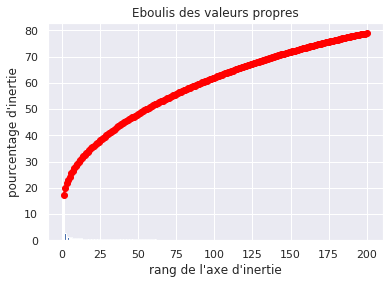

In [69]:
display_scree_plot(preparation_pipeline['dimensionality_reductor'].reductor)

# 2D visualization

In [74]:
pca = PCA(n_components=2)
X_transformed = pca.fit_transform(df_train)
X_test_transformed = pca.fit_transform(df_test)

In [75]:
X_transformed[:,1]

array([ 0.24806574, -0.47915729,  0.28121943, ...,  0.22885646,
       -0.45858262,  0.28289429])

Text(0, 0.5, 'Axe 2')

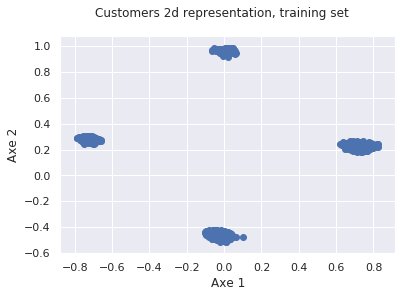

In [76]:
fig = plt.figure()
fig.suptitle('Customers 2d representation, training set')

ax = plt.gca()
#plt.hist(df_nocancel['TotalPrice'], bins=50, range=(0,100))
plt.scatter(X_transformed[:,0], X_transformed[:,1])
#ax.set_xlim([0,500])
plt.xlabel('Axe 1')
plt.ylabel("Axe 2")
#plt.yscale('log')

Text(0, 0.5, 'Axe 2')

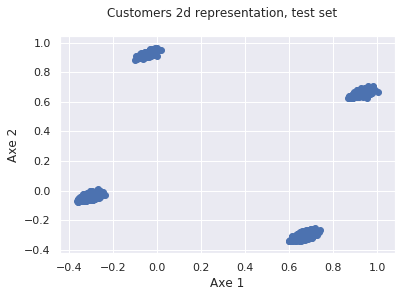

In [77]:
fig = plt.figure()
fig.suptitle('Customers 2d representation, test set')

ax = plt.gca()
#plt.hist(df_nocancel['TotalPrice'], bins=50, range=(0,100))
plt.scatter(X_test_transformed[:,0], X_test_transformed[:,1])
#ax.set_xlim([0,500])
plt.xlabel('Axe 1')
plt.ylabel("Axe 2")
#plt.yscale('log')

# Annex

## Display some data

In [24]:
df_nocancel = df[df['InvoiceNo'].str.startswith('C') == False]
df_nocancel.reset_index(inplace=True)

df_gbproduct = df_nocancel[['StockCode', 'TotalPrice']].groupby('StockCode').sum()['TotalPrice']

In [25]:
df_nocancel.head(2)

,index,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,DescriptionNormalized,InvoiceMonth
0,0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30,WHITE HANGING HEART T-LIGHT HOLDER,2010-12-01 00:00:00
1,1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,WHITE METAL LANTERN,2010-12-01 00:00:00


In [26]:
df_nocancel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 391328 entries, 0 to 391327
Data columns (total 12 columns):
index                    391328 non-null int64
InvoiceNo                391328 non-null object
StockCode                391328 non-null object
Description              391328 non-null object
Quantity                 391328 non-null int64
InvoiceDate              391328 non-null object
UnitPrice                391328 non-null float64
CustomerID               391328 non-null object
Country                  391328 non-null object
TotalPrice               391328 non-null float64
DescriptionNormalized    391328 non-null object
InvoiceMonth             391328 non-null object
dtypes: float64(2), int64(2), object(8)
memory usage: 35.8+ MB


In [27]:
invoice_dates = pd.to_datetime(df_nocancel["InvoiceDate"], format="%Y-%m-%d ")

In [28]:
invoice_dates = pd.to_datetime(df_nocancel["InvoiceDate"])

In [29]:
np.maximum((pd.to_datetime('2011-12-09 12:50:00') - invoice_dates) / (np.timedelta64(1, "M")), 1)[123456]

6.997862150945377

In [30]:
df_gbcustom_firstorder = df_nocancel[['CustomerID', 'InvoiceDate']].groupby('CustomerID').min()

In [31]:
df_nocancel[['CustomerID', 'InvoiceDate']].groupby('CustomerID').min()['InvoiceDate']

CustomerID
12346    2011-01-18 10:01:00
12347    2010-12-07 14:57:00
12348    2010-12-16 19:09:00
12349    2011-11-21 09:51:00
12350    2011-02-02 16:01:00
                ...         
18280    2011-03-07 09:52:00
18281    2011-06-12 10:53:00
18282    2011-08-05 13:35:00
18283    2011-01-06 14:14:00
18287    2011-05-22 10:39:00
Name: InvoiceDate, Length: 4336, dtype: object

In [32]:
(\
   pd.to_datetime('2011-12-09 12:50:00')\
   - pd.to_datetime(df_nocancel[['CustomerID', 'InvoiceDate']].groupby('CustomerID').min()['InvoiceDate'])
)\
  / (np.timedelta64(1, "M"))

CustomerID
12346    10.681693
12347    12.054845
12348    11.753401
12349     0.595472
12350    10.180656
           ...    
18280     9.104864
18281     5.916549
18282     4.138689
18283    11.070179
18287     6.606821
Name: InvoiceDate, Length: 4336, dtype: float64

In [33]:
# Number of months between first order date and last date of the dataset
series_gbclient_nbmonths = np.maximum(\
(
   (
   pd.to_datetime('2011-12-09 12:50:00')\
   - pd.to_datetime(df_nocancel[['CustomerID', 'InvoiceDate']].groupby('CustomerID').min()['InvoiceDate'])
   )\
    / (np.timedelta64(1, "M"))
), 1)

In [34]:
df_nocancel[['CustomerID', ]]

,CustomerID
0,17850
1,17850
2,17850
3,17850
4,17850
...,...
391323,12680
391324,12680
391325,12680
391326,12680


In [35]:
df_gbcustom_firstorder

,InvoiceDate
CustomerID,
12346,2011-01-18 10:01:00
12347,2010-12-07 14:57:00
12348,2010-12-16 19:09:00
12349,2011-11-21 09:51:00
12350,2011-02-02 16:01:00
...,...
18280,2011-03-07 09:52:00
18281,2011-06-12 10:53:00
18282,2011-08-05 13:35:00


In [36]:
df_nocancel[df_nocancel['CustomerID'] == '18281'].sort_values(by='InvoiceDate', ascending=True)

,index,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,DescriptionNormalized,InvoiceMonth
153118,156809,556464,22037,ROBOT BIRTHDAY CARD,12,2011-06-12 10:53:00,0.42,18281,United Kingdom,5.04,ROBOT BIRTHDAY CARD,2011-06-01 00:00:00
153119,156810,556464,22716,CARD CIRCUS PARADE,12,2011-06-12 10:53:00,0.42,18281,United Kingdom,5.04,CARD CIRCUS PARADE,2011-06-01 00:00:00
153120,156811,556464,22028,PENNY FARTHING BIRTHDAY CARD,12,2011-06-12 10:53:00,0.42,18281,United Kingdom,5.04,PENNY FARTHING BIRTHDAY CARD,2011-06-01 00:00:00
153121,156812,556464,23007,SPACEBOY BABY GIFT SET,1,2011-06-12 10:53:00,16.95,18281,United Kingdom,16.95,SPACEBOY BABY GIFT SET,2011-06-01 00:00:00
153122,156813,556464,23008,DOLLY GIRL BABY GIFT SET,1,2011-06-12 10:53:00,16.95,18281,United Kingdom,16.95,DOLLY GIRL BABY GIFT SET,2011-06-01 00:00:00
153123,156814,556464,23209,LUNCH BAG DOILEY PATTERN,10,2011-06-12 10:53:00,1.65,18281,United Kingdom,16.50,LUNCH BAG VINTAGE DOILY,2011-06-01 00:00:00
153124,156815,556464,22467,GUMBALL COAT RACK,6,2011-06-12 10:53:00,2.55,18281,United Kingdom,15.30,GUMBALL COAT RACK,2011-06-01 00:00:00


In [37]:
invoice_dates[2000:2010]

2000   2010-12-02 09:43:00
2001   2010-12-02 09:43:00
2002   2010-12-02 09:43:00
2003   2010-12-02 09:43:00
2004   2010-12-02 09:43:00
2005   2010-12-02 09:43:00
2006   2010-12-02 09:43:00
2007   2010-12-02 09:43:00
2008   2010-12-02 09:44:00
2009   2010-12-02 09:44:00
Name: InvoiceDate, dtype: datetime64[ns]

In [38]:
df_nocancel.loc[2000:2010,'InvoiceDate']

2000    2010-12-02 09:43:00
2001    2010-12-02 09:43:00
2002    2010-12-02 09:43:00
2003    2010-12-02 09:43:00
2004    2010-12-02 09:43:00
2005    2010-12-02 09:43:00
2006    2010-12-02 09:43:00
2007    2010-12-02 09:43:00
2008    2010-12-02 09:44:00
2009    2010-12-02 09:44:00
2010    2010-12-02 09:44:00
Name: InvoiceDate, dtype: object

In [39]:
df_nocancel.loc[100000:100010,'InvoiceMonth']

100000    2011-04-01 00:00:00
100001    2011-04-01 00:00:00
100002    2011-04-01 00:00:00
100003    2011-04-01 00:00:00
100004    2011-04-01 00:00:00
100005    2011-04-01 00:00:00
100006    2011-04-01 00:00:00
100007    2011-04-01 00:00:00
100008    2011-04-01 00:00:00
100009    2011-04-01 00:00:00
100010    2011-04-01 00:00:00
Name: InvoiceMonth, dtype: object

In [40]:
df[df['InvoiceNo'].str.startswith('C') == True]['CustomerID'].unique()

array(['14527', '15311', '17548', ..., '12985', '15951', '16446'],
      dtype=object)

In [41]:
# Product codes that contain chars instead of numbers
df[df['StockCode'].str.isalpha()]['StockCode'].unique()

array(['D'], dtype=object)

# For debug / test (clean code is in functions.py)

In [42]:
df_train = df_train_ori
df_test = df_test_ori

In [43]:
df_train.head(6)

,index,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,DescriptionNormalized,InvoiceMonth
0,11503,537781,21377,SMALL CAMPHOR WOOD FIELD MUSHROOM,1,2010-12-08 12:46:00,1.65,17341,United Kingdom,1.65,SMALL CAMPHOR WOOD FIELD MUSHROOM,2010-12-01 00:00:00
1,40887,541855,21947,SET OF 6 HEART CHOPSTICKS,1,2011-01-23 14:59:00,1.25,13742,United Kingdom,1.25,SET OF 6 HEART CHOPSTICKS,2011-01-01 00:00:00
2,103799,549646,85031A,ROMANTIC IMAGES SCRAP BOOK SET,6,2011-04-11 11:51:00,1.25,12982,United Kingdom,7.50,ROMANTIC IMAGES SCRAP BOOK SET,2011-04-01 00:00:00
3,372911,578856,23535,WALL ART BICYCLE SAFETY,4,2011-11-27 11:18:00,5.95,17769,United Kingdom,23.80,WALL ART BICYCLE SAFETY,2011-11-01 00:00:00
4,297823,571747,23396,LE JARDIN BOTANIQUE CUSHION COVER,4,2011-10-19 10:59:00,3.75,13849,United Kingdom,15.00,LE JARDIN BOTANIQUE CUSHION COVER,2011-10-01 00:00:00
5,359556,577535,21098,CHRISTMAS TOILET ROLL,3,2011-11-20 14:07:00,1.25,14071,United Kingdom,3.75,CHRISTMAS TOILET ROLL,2011-11-01 00:00:00


In [44]:
df_train

,index,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,DescriptionNormalized,InvoiceMonth
0,11503,537781,21377,SMALL CAMPHOR WOOD FIELD MUSHROOM,1,2010-12-08 12:46:00,1.65,17341,United Kingdom,1.65,SMALL CAMPHOR WOOD FIELD MUSHROOM,2010-12-01 00:00:00
1,40887,541855,21947,SET OF 6 HEART CHOPSTICKS,1,2011-01-23 14:59:00,1.25,13742,United Kingdom,1.25,SET OF 6 HEART CHOPSTICKS,2011-01-01 00:00:00
2,103799,549646,85031A,ROMANTIC IMAGES SCRAP BOOK SET,6,2011-04-11 11:51:00,1.25,12982,United Kingdom,7.50,ROMANTIC IMAGES SCRAP BOOK SET,2011-04-01 00:00:00
3,372911,578856,23535,WALL ART BICYCLE SAFETY,4,2011-11-27 11:18:00,5.95,17769,United Kingdom,23.80,WALL ART BICYCLE SAFETY,2011-11-01 00:00:00
4,297823,571747,23396,LE JARDIN BOTANIQUE CUSHION COVER,4,2011-10-19 10:59:00,3.75,13849,United Kingdom,15.00,LE JARDIN BOTANIQUE CUSHION COVER,2011-10-01 00:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...
359915,128343,552843,22692,DOORMAT WELCOME TO OUR HOME,1,2011-05-11 14:37:00,7.95,14649,United Kingdom,7.95,DOORMAT WELCOME TO OUR HOME,2011-05-01 00:00:00
359916,272049,569401,23356,LOVE HOT WATER BOTTLE,3,2011-10-04 08:56:00,5.95,15111,United Kingdom,17.85,LOVE HOT WATER BOTTLE,2011-10-01 00:00:00
359917,225276,564554,23280,FOLDING BUTTERFLY MIRROR HOT PINK,1,2011-08-25 19:39:00,0.83,17189,United Kingdom,0.83,FOLDING BUTTERFLY MIRROR HOT PINK,2011-08-01 00:00:00
359918,302898,572274,22423,REGENCY CAKESTAND 3 TIER,16,2011-10-21 16:48:00,10.95,14031,United Kingdom,175.20,REGENCY CAKESTAND 3 TIER,2011-10-01 00:00:00


In [45]:
df_train_nocancel = df_train[df_train['InvoiceNo'].str.startswith('C') == False]
df_train_nocancel.reset_index(inplace=True)

In [46]:
feat_list = ['CustomerID', 'TotalPrice']
feat_list_bow = [col for col in df_train_nocancel if col.startswith('DescriptionNormalized_')]
feat_list.extend(feat_list_bow)

In [47]:
feat_list

['CustomerID', 'TotalPrice']

In [48]:
df_train_gbcust_nocancel = df_train_nocancel[feat_list].groupby('CustomerID').sum()

In [49]:
df_train_gbcust_nocancel[feat_list_bow] = df_train_gbcust_nocancel[feat_list_bow].clip(upper=1)

In [50]:
df_train_gbcust_nocancel

,TotalPrice
CustomerID,
12346,77183.60
12347,3956.22
12348,1416.84
12349,1292.19
12350,279.40
...,...
18280,156.90
18281,80.82
18282,173.01


In [51]:
# Number of months between first order date and last date of the dataset
series_train_gbclient_nbmonths = np.maximum(\
(
   (
   pd.to_datetime('2011-12-09 12:50:00')\
   - pd.to_datetime(df_train_nocancel[['CustomerID', 'InvoiceDate']].groupby('CustomerID').min()['InvoiceDate'])
   )\
    / (np.timedelta64(1, "M"))
), 1)

In [52]:
series_train_gbclient_nbmonths

CustomerID
12346    10.681693
12347    12.054845
12348    11.753401
12349     1.000000
12350    10.180656
           ...    
18280     9.104864
18281     5.916549
18282     4.138689
18283    11.070179
18287     6.606821
Name: InvoiceDate, Length: 4332, dtype: float64

In [53]:
df_train_gbcust_nocancel['TotalPrice'] 

CustomerID
12346    77183.60
12347     3956.22
12348     1416.84
12349     1292.19
12350      279.40
           ...   
18280      156.90
18281       80.82
18282      173.01
18283     1837.51
18287     1684.52
Name: TotalPrice, Length: 4332, dtype: float64

In [54]:
df_train_gbcust_nocancel['TotalPrice'] = df_train_gbcust_nocancel['TotalPrice'] / series_train_gbclient_nbmonths

In [55]:
df_train_gbcust_nocancel

,TotalPrice
CustomerID,
12346,7225.783259
12347,328.185062
12348,120.547233
12349,1292.190000
12350,27.444203
...,...
18280,17.232547
18281,13.659991
18282,41.803096


In [56]:
df_train

,index,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,DescriptionNormalized,InvoiceMonth
0,11503,537781,21377,SMALL CAMPHOR WOOD FIELD MUSHROOM,1,2010-12-08 12:46:00,1.65,17341,United Kingdom,1.65,SMALL CAMPHOR WOOD FIELD MUSHROOM,2010-12-01 00:00:00
1,40887,541855,21947,SET OF 6 HEART CHOPSTICKS,1,2011-01-23 14:59:00,1.25,13742,United Kingdom,1.25,SET OF 6 HEART CHOPSTICKS,2011-01-01 00:00:00
2,103799,549646,85031A,ROMANTIC IMAGES SCRAP BOOK SET,6,2011-04-11 11:51:00,1.25,12982,United Kingdom,7.50,ROMANTIC IMAGES SCRAP BOOK SET,2011-04-01 00:00:00
3,372911,578856,23535,WALL ART BICYCLE SAFETY,4,2011-11-27 11:18:00,5.95,17769,United Kingdom,23.80,WALL ART BICYCLE SAFETY,2011-11-01 00:00:00
4,297823,571747,23396,LE JARDIN BOTANIQUE CUSHION COVER,4,2011-10-19 10:59:00,3.75,13849,United Kingdom,15.00,LE JARDIN BOTANIQUE CUSHION COVER,2011-10-01 00:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...
359915,128343,552843,22692,DOORMAT WELCOME TO OUR HOME,1,2011-05-11 14:37:00,7.95,14649,United Kingdom,7.95,DOORMAT WELCOME TO OUR HOME,2011-05-01 00:00:00
359916,272049,569401,23356,LOVE HOT WATER BOTTLE,3,2011-10-04 08:56:00,5.95,15111,United Kingdom,17.85,LOVE HOT WATER BOTTLE,2011-10-01 00:00:00
359917,225276,564554,23280,FOLDING BUTTERFLY MIRROR HOT PINK,1,2011-08-25 19:39:00,0.83,17189,United Kingdom,0.83,FOLDING BUTTERFLY MIRROR HOT PINK,2011-08-01 00:00:00
359918,302898,572274,22423,REGENCY CAKESTAND 3 TIER,16,2011-10-21 16:48:00,10.95,14031,United Kingdom,175.20,REGENCY CAKESTAND 3 TIER,2011-10-01 00:00:00


In [57]:
custid_cancelled = df_train[df_train['InvoiceNo'].str.startswith('C') == True]['CustomerID'].unique()